In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
data = pd.read_csv('train.csv')

In [44]:
def convert_one_hot(x):
    b = np.zeros((len(x),10))
    for i in range(len(x)):
        a = np.zeros(10)
        a[x[i]] = 1
        b[i] = a
    return b
data = np.array(data)
test_data = data[0:999]
train_data = data[1000:len(data)]
train_labels_number = train_data[:, 0]
train_labels = convert_one_hot(train_labels_number)
train_layers = train_data[:, 1:train_data.shape[0]]/255
test_labels_number = test_data[:, 0]
test_labels = convert_one_hot(test_labels_number)
test_layers = test_data[:, 1:test_data.shape[0]]/255

In [49]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def d_sigmoid(x):
    return(np.exp(x)/np.square(np.exp(x)+1) + 1e-15)

def ReLU(x):
    #return 1/(1 + np.exp(-x))
    return np.maximum(0, x)

def d_ReLU(x):
    #return(np.exp(x)/np.square(np.exp(x)+1))
    return x > 0

def norm(x):
    #print(np.max(x))
    return x/(np.max(x) + 1e-15)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def ssd(y, p): #sum of squared differences
    squared_diff = np.square(y - p)
    return np.sum(squared_diff)

def d_sd(y, p): #derivative of squared difference
    return 2 * (y - p)

def sum_cross_ent(y, p):
    p += np.full(p.shape, 1e-15) #to prevent log(0)
    return np.sum(-(y * np.log(p) + (1 - y) * np.log(1 - p)))

def d_cross_ent(y, p):
    p += np.full(p.shape, 1e-15) #to prevent division by zero
    return ((1 - y) / (1 - p)) - (y / p)

class Net: # accepts a tuple indicating the number of nodes in each layer. contains the weights array and biases vector for each layer

    def __init__(self, layers): # must have atleast 2 layers (2 items in the layers tuple)
        self.layers = layers #tuple
        self.weights = []
        for i in range(1, len(layers)):
            self.weights.append(np.random.rand(layers[i],layers[i-1])/500)
        self.biases = []
        for i in range(1, len(layers)):
            self.biases.append(np.random.rand(layers[i]))
        self.net = [] # contains activations
        for i in range(len(layers)):
            self.net.append(np.zeros((layers[i])))

    def dump(self):
        print("DUMP========")
        print(self.biases)
        print(self.weights)
        
    def act(self, x):
        return sigmoid(x)
    
    def d_act(self, x):
        return d_sigmoid(x)
        
    def loss(self, expected, actual): #for one training example
        #return sum_cross_ent(expected, actual)
        return ssd(expected, actual)
    
    def d_loss(self, expected, actual): #for one training example
        #return d_cross_ent(expected, actual)
        return d_sd(expected, actual)
    
    def emp_loss(self, labels, inputs): #empirical loss, for whole testing set
        loss_array = np.zeros((len(inputs)))
        for i in range(len(inputs)):
            output = self.forward(inputs[i])
            loss_array[i] = self.loss(labels[i], output)
        return np.mean(loss_array)
    
    def acc(self, labels_num, inputs):
        successes = 0
        for i in range(len(inputs)):
            output = self.forward(inputs[i])
            prediction = np.where(output == output.max())[0][0]
            if prediction == labels_num[i]:
                successes+=1
        return successes/len(inputs)
    
    def forward(self, input_layer):
        self.net[0] = input_layer
        for i in range(1, len(self.net)):
            self.net[i] = self.act(np.dot(self.weights[i-1], self.net[i-1]) + self.biases[i-1])
        out = self.net[len(self.net)-1]
        normalized = norm(out)
        return softmax(normalized)

    def backprop(self, label, example): # for one training example
        l = self.forward(example)
        d_w = []
        for i in range(len(self.layers)-1):
            d_w.append(np.zeros((self.layers[i+1],self.layers[i])))
        d_b = []
        for i in range(len(self.layers)-1):
            d_b.append(np.zeros((self.layers[i+1])))
        d_a = [] 
        for i in range(len(self.layers)):
            d_a.append(np.zeros((self.layers[i])))

        #d_cost = 2 * (self.net[len(self.layers)-1] - label)
        d_a[len(self.layers)-1] = self.d_loss(self.net[len(self.layers)-1], label)

        for i in reversed(range(len(self.layers)-1)):
            for j in range(len(self.net[i])):
                for k in range(len(self.net[i+1])):
                    #calculates z for the whole layer (layer i)
                    z_layer = np.dot(self.weights[i][k], self.net[i]) + self.biases[i][k]
                    #calculates z for this specific node (layer i, index j)
                    z = self.weights[i][k][j] * self.net[i][j] + self.biases[i][k]
                    #calculates the suggested change 
                    d_a[i][j] += (self.weights[i][k][j] * self.d_act(z_layer) * d_a[i+1][k])/len(self.net[i+1])
                    d_b[i][k] += (self.d_act(z_layer) * d_a[i+1][k])/len(self.net[i+1])
                    d_w[i][k][j] = self.net[i][j] * self.d_act(z) * d_a[i+1][k]
        return d_w, d_b

    def train(self, data, labels, batch_size, rate, *, batches=0): #labels and data are arrays of vectors (or 2d arrays), 1 epoch
        #np.random.shuffle(data)
        data_batched = np.zeros((math.floor(len(data)/batch_size), batch_size, self.layers[0]))
        labels_batched = np.zeros((math.floor(len(data)/batch_size), batch_size, self.layers[len(self.layers) - 1]))
        for i in range(math.floor(len(data)/batch_size)):
            for j in range(batch_size):
                data_batched[i][j] = data[i*batch_size + j]
                labels_batched[i][j] = labels[i*batch_size + j]
        
        batch_count = batches
        if (batches == 0):
            batch_count = len(data_batched)
        for i in range(batch_count):
            #self.dump()
            print("\n\nbatch", i)
            d_weights_list = []
            d_biases_list = []
            d_weights = []
            for j in range(1, len(self.layers)):
                d_weights.append(np.zeros((self.layers[j],self.layers[j-1])))
            d_biases = []
            for j in range(len(self.layers)-1):
                d_biases.append(np.zeros((self.layers[j+1])))
            for j in range(len(data_batched[i])):
                this_d_weights, this_d_biases = self.backprop(labels_batched[i][j], data_batched[i][j])
                d_weights_list.append(this_d_weights)
                d_biases_list.append(this_d_biases)
            for j in range(len(self.layers)-1):    
                for k in range(len(data_batched[i])):
                    d_weights[j] += d_weights_list[k][j]
                    d_biases[j] += d_biases_list[k][j]
                d_weights[j] = d_weights[j]/len(data_batched[j])
                d_biases[j] = d_biases[j]/len(data_batched[j])
                self.weights[j] = np.subtract(self.weights[j], rate * d_weights[j])
                self.biases[j] = np.subtract(self.biases[j], rate * d_biases[j])
            if i % 5 == 0:
                print("loss:", self.emp_loss(test_labels, test_layers))
                print("accuracy:", self.acc(test_labels_number, test_layers))

create net
loss: 0.9010889682844117


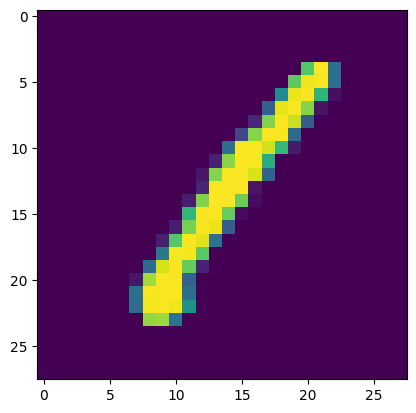

train for one epoch


batch 0
loss: 0.9181879372853808
accuracy: 0.0890890890890891


batch 1


batch 2


batch 3


batch 4


batch 5
loss: 0.9162736381128176
accuracy: 0.0960960960960961


batch 6


batch 7


batch 8


batch 9


batch 10
loss: 0.915450202019185
accuracy: 0.10510510510510511


batch 11


batch 12


batch 13


batch 14


batch 15
loss: 0.9167631883976857
accuracy: 0.09309309309309309


batch 16


batch 17


batch 18


batch 19


batch 20
loss: 0.9142810217040911
accuracy: 0.09309309309309309


batch 21


batch 22


batch 23


batch 24


batch 25
loss: 0.9123217976740503
accuracy: 0.0970970970970971


batch 26


batch 27


batch 28


batch 29


batch 30
loss: 0.9094139815256695
accuracy: 0.0970970970970971


batch 31


batch 32


batch 33


batch 34


batch 35
loss: 0.9038187253828628
accuracy: 0.0970970970970971


batch 36


batch 37


batch 38


batch 39


batch 40
loss: 0.9019065916167589
accuracy: 0.0960960960960961


batch 41


batch 42


batch 43


batch 44


batch

C:\Users\muyan\AppData\Local\Temp\ipykernel_5580\2582316246.py:5: RuntimeWarning: overflow encountered in square
  return(np.exp(x)/np.square(np.exp(x)+1) + 1e-15)




batch 2497


batch 2498


batch 2499


batch 2500
loss: 0.7518297123860767
accuracy: 0.6706706706706707


batch 2501


batch 2502


batch 2503


batch 2504


batch 2505
loss: 0.7514799800243981
accuracy: 0.6646646646646647


batch 2506


batch 2507


batch 2508


batch 2509


batch 2510
loss: 0.7498007302528837
accuracy: 0.6396396396396397


batch 2511


batch 2512


batch 2513


batch 2514


batch 2515
loss: 0.7515003128743489
accuracy: 0.6616616616616616


batch 2516


batch 2517


batch 2518


batch 2519


batch 2520
loss: 0.7608269729511365
accuracy: 0.6356356356356356


batch 2521


batch 2522


batch 2523


batch 2524


batch 2525
loss: 0.7526588649379211
accuracy: 0.6296296296296297


batch 2526


batch 2527


batch 2528


batch 2529


batch 2530
loss: 0.7497453891801213
accuracy: 0.6666666666666666


batch 2531


batch 2532


batch 2533


batch 2534


batch 2535
loss: 0.7545923561602659
accuracy: 0.6486486486486487


batch 2536


batch 2537


batch 2538


batch 2539


batch 2

C:\Users\muyan\AppData\Local\Temp\ipykernel_5580\2582316246.py:5: RuntimeWarning: overflow encountered in exp
  return(np.exp(x)/np.square(np.exp(x)+1) + 1e-15)
C:\Users\muyan\AppData\Local\Temp\ipykernel_5580\2582316246.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return(np.exp(x)/np.square(np.exp(x)+1) + 1e-15)


loss: nan


IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
print("create net")
testnet = Net((784, 10, 10))
print("loss:", testnet.emp_loss(test_labels, test_layers))
#print("net created, calculating initial loss")
#print(testnet.loss(test_layers, test_labels))
#testnet.dump()

img0 = np.array(data[0][1:785])
plt.imshow(np.reshape(img0, (28,28)))
plt.show()
#plt.imshow(train_imgs[1])
#plt.show()
#plt.imshow(train_imgs[2])
#plt.show()
#print(testnet.forward(data[0][1:785]))
#print(testnet.forward(train_input_layers[1]))
#print(testnet.forward(train_input_layers[2]))

print("train for one epoch")
testnet.train(train_layers, train_labels, 10, 10)